**Overview to this notebook**

[1️⃣ Introduction](#intro)   
[2️⃣ Methods](#methods)   
[3️⃣ Results](#results)   
[4️⃣ Conclusion](#conclusion)   
[5️⃣ References](#refs)   
[6️⃣ Division of Labor](#labor)  

<h1 id = intro style = 'font-size:32px; padding: 10px; padding-left: 15px; background-color: #E5E5E5; border-radius: 10px;'>
    <b>
        1. Introduction
    </b>
</h1>

This research project examines the effectiveness of Convolutional Neural Networks (CNN) and Vision Transformers (ViT) in image classification, using a subset of the "WikiArt" collection from Kaggle. This subset features around 42,500 paintings across 13 art movements. Drawing from [Dosovitskiy et al. (2021)](#refs), who introduced Vision Transformers, we aim to compare the performance of the pre-trained Vision Transformer and ResNet50 (a CNN model), specifically fine-tuned to this dataset. Our evaluation metric is binary accuracy, focusing on the classification of two art styles: Japanese Art and Art Nouveau.

This specific classification task is inspired by [Rebollar & Graña (2022)](#refs), who identified similarities between these styles using CNNs with the "WikiArt" dataset. They presented a connection in a directed graph based on a DenseNet-121 model's confusion matrix. This insight led us to explore these particular two styles as a binary classification problem, hypothesizing that ViT might be more suited for this challenge.

We further hypothesize that ViT could outperform CNNs, particularly in distinguishing nuanced art styles backed by [Raghu et al. (2019)](refs), who noted ViTs' superior spatial location information retention in higher layers compared to ResNets. Such precision in capturing spatial details could be crucial in art classification, offering deeper insights into an artwork’s composition and structure.

Further supporting our hypothesis, [Maurício et al. (2023)](#refs) found that ViTs are more effective in smaller datasets due to their self-attention mechanism, which enhances image relationship analysis. Considering the relatively modest size of our "WikiArt" dataset, this could lead to another advantage for the ViT.

Additionally, we set up a mini-study to investigate a benchmark for human accuracy in this task. By asking 43 people to classify 10 images, we found that they achieved an average accuracy of 82.3%.

At the end of this notebook, you will find a discussion of our results, and implementations of techniques aimed at helping to understand what the ViT does differently in this classification task compared to the CNN.

<h1 id=methods style = 'font-size:32px; padding: 10px; padding-left: 15px; background-color: #E5E5E5; border-radius: 10px;'>
    <b>
        2. Methods
    </b>
</h1>


In this section we:   
*     2.1 Import all packages and functions needed for the whole notebook  
*     2.2 We describe the original data and how we handeled the loading, splitting, and data augmentation.  
*     2.3 Finally, this section includes architecture implementations.  

## 2.1 Setup
All required functions and packages for this Notebook are imported in the following section.

In [1]:
# Core modules
import numpy as np 
import pandas as pd
import keras 
import tensorflow as tf

# Managing files and directories
import os
import shutil

# Data 
from keras.preprocessing.image import ImageDataGenerator as IDG

# Data Visualization
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Visualization of Paintings
from IPython.display import Image

# Model
from keras.applications import ResNet50
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

#Transformer Architecture
import tensorflow.keras.layers as L
import glob, warnings
!pip install vit_keras
from vit_keras import vit

# Post-hoc explainability
!pip install tf-explain
from tf_explain.core.grad_cam import GradCAM
from PIL import Image
from vit_keras import visualize
!pip install visualkeras
import visualkeras


c:\Users\Data_Science\anaconda3\envs\deep_learn\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## 2.2 Data


### 2.2.1 Selecting 


In [2]:
# Define input directory
path = "./input/dataset"
# Define models directory
model_path = "./input/cnn-vit-models"

# Class names
class_names = sorted(os.listdir(path))

#specify our selected classes
class_names_bin = ["African", "Asian"] 
n_classes = len(class_names_bin)

### 2.2.2 Splitting the Data

In [3]:
# Define paths
test_data_dir = "./input/dataset/test"
train_data_dir = "./input/dataset/train"
validation_data_dir = "./input/dataset/validation"

# Create folder for saving the models later 
if not os.path.exists("_models"):
    os.makedirs("_models")

# Split the data into training and validation sets
# Check if the directories exist
if os.path.exists(validation_data_dir):
    print("Validation directory is already exist. Pass to the next step.")
else:
    # check the train-test split ratio 
    test_files = 0
    train_files = 0
    total_files = 0
    for class_name in os.listdir(train_data_dir):
        class_dir = os.path.join(test_data_dir, class_name)
        test_files += len(os.listdir(class_dir))
        class_dir = os.path.join(train_data_dir, class_name)
        train_files += len(os.listdir(class_dir))
    total_files = test_files + train_files
    
    # Set splitting rates
    validation_split_in_total = 0.1
    train_split_in_total = train_files/total_files
    validation_split_in_train = validation_split_in_total/train_split_in_total
    
    # Iterate over the classes (African and Asian)
    for class_name in os.listdir(train_data_dir):
        class_dir = os.path.join(train_data_dir, class_name)
        
        # Ensure it's a directory
        if os.path.isdir(class_dir):
            # List all files in the class directory
            files = os.listdir(class_dir)
            class_files = len(files)
            percentage_class = class_files/train_files
            validation_split_in_train_class = validation_split_in_train
            
            # Shuffle the files randomly
            random.shuffle(files)
            
            # Calculate the number of validation samples
            num_validation_samples = int(len(files) * validation_split_in_train_class)
            
            # Split the files into training and validation sets
            validation_files = files[:num_validation_samples]
            training_files = files[num_validation_samples:]
            
            # Create destination directories if they don't exist
            os.makedirs(os.path.join(validation_data_dir, class_name), exist_ok=True)
            
            # Move validation files to validation directory
            for file_name in validation_files:
                src = os.path.join(class_dir, file_name)
                dst = os.path.join(validation_data_dir, class_name, file_name)
                shutil.move(src, dst)
        



Validation directory is already exist. Pass to the next step.


In [4]:
# Print data distribution
# count the number of files in all the subsets
total_files = 0
# count the number of files in each subset using a dictionary
subset_files = {}
for subset in os.listdir(path):
    for class_path in class_names_bin:
        lst = os.listdir(os.path.join(path, subset, class_path))
        no_files = len(lst)
        txt = "The {subset} set contains {no_files} images of {class_path} elephants."
        print(txt.format(subset=subset, no_files=no_files, class_path=class_path))
    subset_files[subset] = int(len(os.listdir(os.path.join(path, subset, class_names_bin[0])))) + int(len(os.listdir(os.path.join(path, subset, class_names_bin[1]))))
    total_files += subset_files[subset]

# print the total number of files
print("\nThe total number of images in the dataset is", total_files)
# print the number of files in each subset as a percentage of the total number of files
print("The train set contains %.2f%% of the images." % (100*subset_files["train"]/total_files))
print("The test set contains %.2f%% of the images." % (100*subset_files["test"]/total_files))
print("The validation set contains %.2f%% of the images." % (100*subset_files["validation"]/total_files))

The test set contains 97 images of African elephants.
The test set contains 91 images of Asian elephants.
The train set contains 369 images of African elephants.
The train set contains 369 images of Asian elephants.
The validation set contains 51 images of African elephants.
The validation set contains 51 images of Asian elephants.

The total number of images in the dataset is 1028
The train set contains 71.79% of the images.
The test set contains 18.29% of the images.
The validation set contains 9.92% of the images.


### 2.2.3 Data Generation Function & Data Augmentation
We are using the `flow_from_directory` function because it allows us to save RAM by not loading all the images at once. It also offers a built in data augmentation feature through `ImageDataGenerator`.  As augmentation we implemented rotating up to 25 degrees, zooming by 10%, horizontal flipping, and shifting the width and height by 20%. Additionally, images are rescaled for normalization, and a shear transformation of 15% is applied, with 'nearest' used as the fill mode for newly created pixels.

In [5]:
# Loading artworks and splitting data for training and validation
batch_size = 64
train_input_shape = (224, 224, 3)
n_classes = len(class_names_bin)

# Define Image Data Generator and data augmentation techniques
datagen = IDG(
    rescale = 1./255.,
    rotation_range= 25, 
    fill_mode='nearest',
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
)

datagen_test = IDG(rescale= 1./255.)

# Training Set
train_ds = datagen.flow_from_directory(
    os.path.join(path, "train"),
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',  # depending on number of nodes in the output layer
    classes=class_names_bin  # Here we can speify our classes (or take class_names for all)
)

# Validation Set
valid_ds = datagen.flow_from_directory(
    os.path.join(path, "validation"),
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',  # depending on number of nodes in the output layer
    classes=class_names_bin # Here we can speify our classes (or take class_names for all)
)

# Test Set
test_ds = datagen_test.flow_from_directory(
    os.path.join(path, "test"),
    target_size=train_input_shape[0:2],
    batch_size=1,
    shuffle=False,
    class_mode='categorical',  # depending on number of nodes in the output layer
    classes=class_names_bin # Here we can specify our classes (or take class_names for all)
)

# Add training steps
Step_Train = train_ds.n//train_ds.batch_size
Step_Validation = valid_ds.n//valid_ds.batch_size
print("Total number of batches =", Step_Train, "and", Step_Validation)

Found 738 images belonging to 2 classes.
Found 102 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
Total number of batches = 11 and 1


<hr>

## 2.3 Implementing the Architectures

Before comparing convolutional neural network and the vision transformer, we should try and understand how each architecture actually works.  
  
**Convolutional Neural Network**   
This architecture looks for patterns of shapes and colours that distinguish between image classes most consistantly. They usually consist of a sequence of convolution layers and pooling layers which together exaggerate specific features of the image.
  
**Vision Transformers**  
This aechitecture was originally designed for natural language processing, but than it was adoppted for computer vision tasks. Transformers originally looked for relationships between words, but when it comes to computer vision they split the image into patches and treat these pathches as words. This means that ViTs (vision transformers) look for relationship between different parts of images and creates relational information. For further understanding of Vision Transformers, we recommend the original paper by [Dosovitskiy et al. (2021)](http://arxiv.org/abs/2010.11929) 

The `head_training` function in the next code chunk was implemented by us to make the notebook neater. The training process of both models is conducted using this function, as we maintained the same adjustment process for both model trainings to ensure comparability. In case the 5-6 hours of training the models with GPU T4 x2 take up too much time, it is possible to skip training and load previously ran and saved models with the same setting by setting the `skip_training = True`.

In [6]:
def head_training(model_base, model_name, skip_training = False, n_epochs = 100):
    '''
    This function serves two purposes:
    1. It is a unified apporach to attaching the head, setting the optimizer, loss, metrics, callbacks,
       and further fine tuning parameters for both models, since the head and the training settings don't
       differ from each other between models. That way, we can just call this function on the bases.
    2. Training the models (rather their heads) currently takes around 5-6hrs with GPU T4 x2.
       If you are more interested in working on the results and with already trained models,
       you can set the argument `skip_training = True`, and it will skip the training process and instead
       load both models that are saved in a public kaggle dataset. These models results from a previous 
       training procedure with exactly the same parameters and settings, so it is equal to running the 
       training, but saves time (and would be possible without the use of accelerators).
       
    Input: 
        model_base: Pretrained base models (here: ViT-B16 / ResNet50), 
        model_names: either "CNN" or "ViT"
        skip_training: False (default) for training, True for loading from previous run
        n_epochs: Number of epochs if training (default = 100)
    Output: Trained models either loaded or trained
    '''
    
    ### Build the model
    model = tf.keras.Sequential([
        model_base,
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation = "relu"),
        keras.layers.Dropout(.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation = "relu"),
        keras.layers.Dropout(.2),
        keras.layers.Dense(32, activation = "relu"),
        keras.layers.Dense(2, activation = 'softmax')
    ], name=model_name)

    ### Set optimizer, loss, and metrics
    model.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ['accuracy']
    )
    
    ### Callbacks
    # Early stopping
    early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
        patience = 15, 
        restore_best_weights = True, 
        verbose = 1
    )
    
    # This way we can save the training history
    csv_logger = CSVLogger(model_name + 'training.log', separator=',', append=False)
    
    ### Training or Loading
    # Either skip training by loading previous model
    if skip_training == True:
        model = keras.saving.load_model(model_path + "/model_" + model_name + ".keras", safe_mode=False)
        print("Training was skipped, {} was loaded".format(model_name))
        
    # or train model
    else:
        history = model.fit(
            train_ds,
            validation_data = valid_ds,
            epochs = n_epochs,
            steps_per_epoch = Step_Train,
            validation_steps = Step_Validation,
            callbacks = [early_stopping_callbacks, csv_logger]
        )

        # Save model and architecture to keras file
        model.save("_models/" + "model_" + model_name + ".keras", overwrite=True)
        
        #Explore Training Process
        history_frame = pd.DataFrame(history.history)
        history_frame.loc[:, ['loss', 'val_loss']].plot()
        history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
        print("Maximum validation accuracy: {:5.4f}".format(history_frame['val_accuracy'].max()))

    return(model)

### 2.3.1 CNN Implementation 
Below, you can see a visualization of the final architecture of our CNN model, along with the loading of the base model "ResNet 50" and the training of the model head using the previously implemented `head_training` function.
<hr>

![### 1. CNN using ResNet50](https://github.com/ingo4000/CNN-vs-ViT_ArtStyle/blob/main/CNN_architecture.png?raw=true)

Epoch 1/100
11/11 [==============================] - 43s 4s/step - loss: 0.8145 - accuracy: 0.5208 - val_loss: 5.6598 - val_accuracy: 0.4062
Epoch 2/100
11/11 [==============================] - 39s 4s/step - loss: 0.7362 - accuracy: 0.5534 - val_loss: 2.9649 - val_accuracy: 0.4844
Epoch 3/100
11/11 [==============================] - 37s 3s/step - loss: 0.6921 - accuracy: 0.5742 - val_loss: 0.7548 - val_accuracy: 0.5469
Epoch 4/100
11/11 [==============================] - 39s 4s/step - loss: 0.7152 - accuracy: 0.5757 - val_loss: 0.8393 - val_accuracy: 0.5156
Epoch 5/100
11/11 [==============================] - 37s 3s/step - loss: 0.6611 - accuracy: 0.5994 - val_loss: 1.2987 - val_accuracy: 0.4219
Epoch 6/100
11/11 [==============================] - 36s 3s/step - loss: 0.6847 - accuracy: 0.5935 - val_loss: 1.0080 - val_accuracy: 0.4531
Epoch 7/100
11/11 [==============================] - 35s 3s/step - loss: 0.6906 - accuracy: 0.5831 - val_loss: 1.0866 - val_accuracy: 0.4531
Epoch 8/100
1

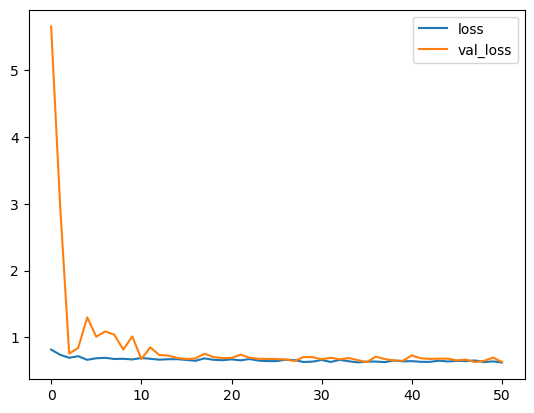

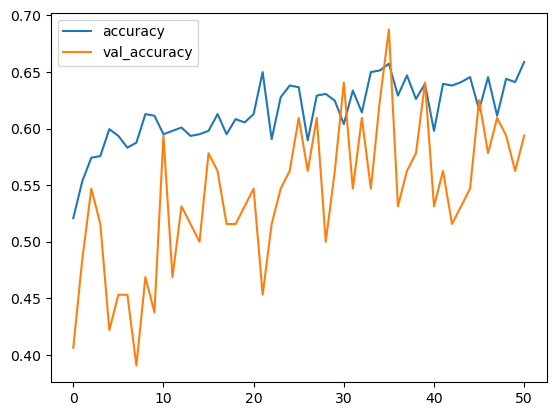

In [7]:
##### Load ResNet50 as pretrained base
ResNet50_base_pretrain = ResNet50(
    input_shape = (224, 224, 3),
    weights = 'imagenet',
    include_top = False,
)
ResNet50_base_pretrain.trainable = False

##### Train or load the model
# To train the model omit the skip_training argument (default: skip_training = False)
# To skip the training and load the model from previous run, set skip_training = True
model_cnn = head_training(
    model_base = ResNet50_base_pretrain, 
    model_name = "CNN", 
    skip_training = False, 
    n_epochs = 100
)

### 2.3.1 ViT Implementation 
Below is a depiction of the final architecture of our ViT model. This includes the code necessary for splitting the image into patches, loading the base model "ViT-B-16," and training the model head with the `head_training` function that we implemented earlier.
<hr>

![### 2. Vision Transformer](https://github.com/ingo4000/CNN-vs-ViT_ArtStyle/blob/main/ViT_architecture.png?raw=true)

#### Setting up image patches
The source of the following implementation of the image patches for the ViT is [this notebook](https://www.kaggle.com/code/utkarshsaxenadn/vit-vision-transformer-in-keras-tensorflow).

In [8]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

c:\Users\Data_Science\anaconda3\envs\deep_learn\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/100
11/11 [==============================] - 186s 16s/step - loss: 0.7262 - accuracy: 0.6217 - val_loss: 0.6253 - val_accuracy: 0.6719
Epoch 2/100
11/11 [==============================] - 175s 16s/step - loss: 0.5945 - accuracy: 0.6973 - val_loss: 0.5896 - val_accuracy: 0.6719
Epoch 3/100
11/11 [==============================] - 168s 15s/step - loss: 0.5573 - accuracy: 0.7255 - val_loss: 0.5898 - val_accuracy: 0.7188
Epoch 4/100
11/11 [==============================] - 165s 15s/step - loss: 0.5430 - accuracy: 0.7329 - val_loss: 0.5463 - val_accuracy: 0.7344
Epoch 5/100
11/11 [==============================] - 169s 15s/step - loss: 0.5609 - accuracy: 0.7329 - val_loss: 0.5711 - val_accuracy: 0.7188
Epoch 6/100
11/11 [==============================] - 170s 16s/step - loss: 0.5197 - accuracy: 0.7404 - val_loss: 0.6296 - val_accuracy: 0.6562
Epoch 7/100
11/11 [==============================] - 180s 16s/step - loss: 0.4787 - accuracy: 0.7730 - val_loss: 0.6153 - val_accuracy: 0.6562

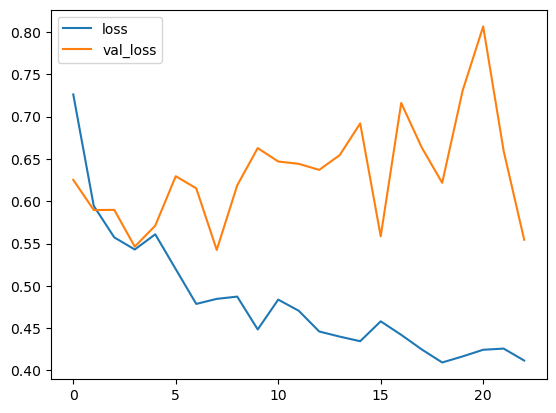

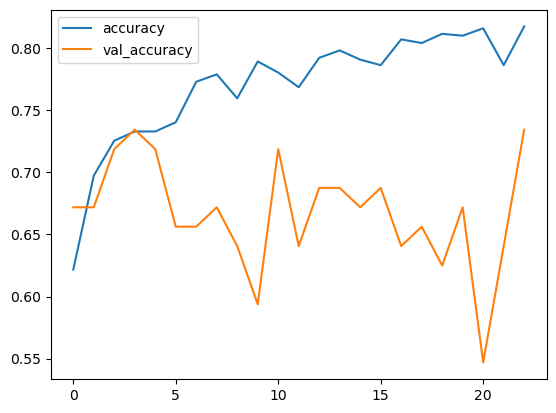

In [9]:
# defining the vit_b16 as pretrained base
image_size = train_input_shape[0]

#### Load pretrained base
vit_base = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax', 
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = n_classes)

vit_base.trainable = False

#### Train or load the model
# To train the model omit the skip_training argument (default: skip_training = False)
# To skip the training and load the model from previous run, set skip_training = True
model_vit = head_training(
    model_base = vit_base, 
    model_name = "ViT", 
    skip_training = False, 
    n_epochs = 100
)

<h1 id=results style = 'font-size:32px; padding: 10px; padding-left: 15px; background-color: #E5E5E5; border-radius: 10px;'>
    <b>
        3. Results
    </b>
</h1>


The Result part of the Notebook contains the following parts:
* 3.1 Overview Training and Fine-Tuning Process
* 3.2 Test Accuracy
* 3.3 Investigate Confusion Matrices
* 3.4 Investigate CNN Misses
* 3.5 Feature Importance

## 3.1 Overview Training and Fine-Tuning Process
After multiple rounds of training and adjustments, we were able to substantially increase the accuracies of both models. The Fine-Tuning Table visualizes our process of training both models. In the process, we tried different techniques to counter the issue of overfitting faced in the initial training rounds. We used dropout layers, data augmentation, and adjusted batch sizes, but ultimately, increasing the number of epochs substantially improved the accuracy of the ViT.

<!DOCTYPE html>
<html>
<head>
    <style>
        table {
            border-collapse: collapse;
            margin-left: 0;
            text-align: left;
        }
        th, td {
            border: 1px solid black;
            padding: 8px;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
</head>
<body>
<h2>Fine-Tuning Table</h2>
<table>
    <tr>
        <th style="text-align: left;">Version</th>
        <th style="text-align: left;">Tuning</th>
        <th style="text-align: left;">CNN Val Accuracy</th>
        <th style="text-align: left;">ViT Val Accuracy</th>
    </tr>
    <tr>
        <td>#11</td>
        <td>Base + 3 Layers Head with Normalization and low Data Augmentation</td>
        <td>0.7305</td>
        <td>0.8828</td>
    </tr>
    <tr>
        <td>#23</td>
        <td>Added Dropout Layers</td>
        <td>0.7344</td>
        <td>0.8828</td>
    </tr>
    <tr>
        <td>#33</td>
        <td>Increased Data Augmentation, Increased Batch Size and Increased Epochs</td>
        <td>0.7090</td>
        <td>0.9219</td>
    </tr>
    <tr>
        <td>#44</td>
        <td>Increase Learning Rate</td>
        <td>0.7158</td>
        <td>0.9326</td>
    </tr>
    <tr>
        <td>#45</td>
        <td>Learning Rate back to default, Increased Epochs (100)</td>
        <td>0.7510</td>
        <td>0.9463</td>
    </tr>
</table>
</body>
</html>

## 3.2 Test Accuracy
The plot below visualizes the test accuracies our models achieved, also compared to the human benchmark accuracy found in our mini-experiment. The plot highlights the impressive performance of the ViT, as it not only substantially outperforms the CNN but also impressively surpasses the benchmark human accuracy.

In [10]:
##### PREDCITIONS ON TEST DATA ######
# True classes
y_true = test_ds.classes

# Make predictions for each of the two models
y_prob_cnn = model_cnn.predict(test_ds)
y_prob_vit = model_vit.predict(test_ds)

# Turn probabilities into class predictions
y_pred_class_cnn = np.argmax(y_prob_cnn, axis=-1)
y_pred_class_vit = np.argmax(y_prob_vit, axis=-1)

# Accuracies
acc_cnn = np.mean(y_pred_class_cnn == y_true)
acc_vit = np.mean(y_pred_class_vit == y_true)

188/188 [==============================] - 46s 228ms/step


CNN model, test set accuracy: 67.02%
ViT model, test set accuracy: 87.77%


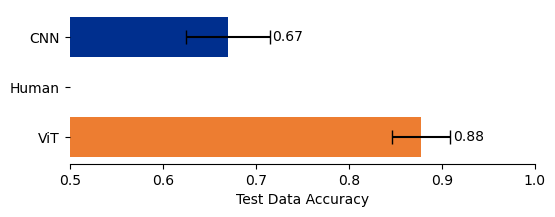

In [11]:
print('CNN model, test set accuracy: {:5.2f}%'.format(100 * acc_cnn))
print('ViT model, test set accuracy: {:5.2f}%'.format(100 * acc_vit))

def se(x,n):
    return(np.sqrt((x*(1-x))/n))

# data
x = ["CNN", "Human", "ViT"]
y = [acc_cnn, 0, acc_vit]
n = [420, 42, 420]
yerr = list(1.96*se(np.array(y),np.array(n)))
colors = ['#002F8E', '#999999', '#ED7D31']

# plot:
fig, ax = plt.subplots(figsize=(6,2))
hbars = ax.barh(x, y, xerr=yerr, 
                capsize=5, align='center', color = colors)
ax.set_yticks(x, labels=x)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Test Data Accuracy')
ax.bar_label(hbars, fmt='%.2f', padding=2)
ax.set_xlim(right=1, left=0.5)  # adjust xlim to fit labels
ax.spines[['left', 'right', 'top']].set_visible(False)

plt.show()

## 3.3 Investigate Confusion Matrices
Inspecting the confusion matrices of our two models, we can see that the misclassifications are not skewed towards one class. Both models seem to misclassify as many images of "Japanese Art" as of "Art Nouveau."

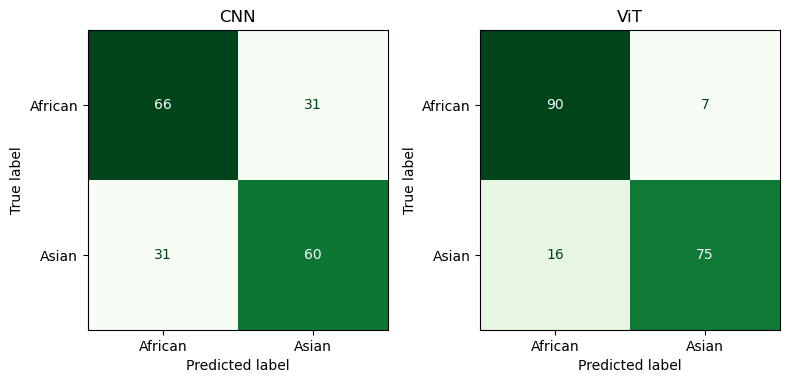

In [12]:
# Define function to plot Confusion matrix depending on model
def plot_CM(model_name, data = test_ds):
    
    if model_name == "CNN":
        pred_labels = y_pred_class_cnn
    elif model_name == "ViT":
        pred_labels = y_pred_class_vit
    else: 
        print("Provide either CNN or ViT as model_name.")
        
    acc_score = np.mean(pred_labels == y_true)
    # get the confusion plot
    cm = sklearn.metrics.confusion_matrix(y_true, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names_bin)
    return(disp)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plot_CM('CNN').plot(ax=ax[0], cmap="Greens", colorbar=False)
ax[0].set_title('CNN')
plot_CM('ViT').plot(ax=ax[1], cmap="Greens", colorbar=False)
ax[1].set_title('ViT')
plt.tight_layout()
plt.show()

## 3.4 Investigate CNN Misses

The CNN exhibits lower accuracy on test data when compared to the ViT. To gain insights, we planned to analyze images that were misclassified by the CNN but correctly identified by the ViT. This analysis could have highlighted specific characteristics that the CNN missed, which the ViT managed to detect, potentially shedding light on the differing capabilities of the two models. However, we were unable to identify specific elements that could explain the differences in the classifications of the two models. You can have a look at these images yourself below:

In [13]:
##### HELPER FUNCTIONS #########
# get all file paths from test dataset
test_file_list = []
for dirname, _, filenames in os.walk(os.path.join(path, "test")):
    for filename in filenames:
        test_file_list.append(os.path.join(dirname, filename))

# Getting class labels by inverting class_indices dictionary
label_to_str = {v: k for k, v in test_ds.class_indices.items()}

#### PLOTTING FUNCTION
# Define a function that plots 1 test set image and their corresponding prediction
def plotting_img_by_idx(idx_list, n_img=1):
    '''
    This functions takes as input a list of index values refering to the indices of the images
    in the test data folder. 
    Setting the n_img argument defines how many random images from that list will be shown. 
    The function returns the randomly selected image(s) from the list of indices
    and displays the respective predictions from both the ViT and the CNN model and their correctness.
    '''
    idx_list = np.array(list(idx_list))
    # get n_img random elements from the list without replacement
    idx_list = idx_list[random.sample(range(0, len(idx_list)), n_img)]
    
    for i in range(len(idx_list)):
        idx = idx_list[i]
        
        for images, labels in [test_ds.__getitem__(idx)]:
            # get true, predicted labels, and softmax probabilities
            true_label = label_to_str[labels[0][1]]
            
            # cnn
            pred_label_cnn = label_to_str[y_pred_class_cnn[idx]]
            prob_cnn = np.max(y_prob_cnn[idx])
            
            # vit
            pred_label_vit = label_to_str[y_pred_class_vit[idx]]
            prob_vit = np.max(y_prob_vit[idx])
            
            # set title colors depending on prediction success
            if pred_label_cnn == true_label:
                color_cnn = 'green'
            else:
                color_cnn = 'red'
            
            # set title colors depending on prediction success
            if pred_label_vit == true_label:
                color_vit = 'green'
            else:
                color_vit = 'red'
            
            # format title labels
            cnn_text = "CNN: {} {:2.0f}% ({})".format(pred_label_cnn, 100*prob_cnn, pred_label_cnn == true_label)
            vit_text = "ViT: {} {:2.0f}% ({})".format(pred_label_vit, 100*prob_vit, pred_label_vit == true_label)
            
            plt.figure(figsize=(4, 4))
            plt.imshow(images[0])
            plt.title(cnn_text, color=color_cnn, x=0.5, y=1)
            plt.suptitle(vit_text, color=color_vit,x=0.5, y=0.99)
            plt.axis("off")
            plt.show()

In [14]:
false_cnn_idx = np.flatnonzero((y_true != y_pred_class_cnn))
false_vit_idx = np.flatnonzero((y_true != y_pred_class_vit))

# set intersection give us the commonly shared image id's of the two lists
false_both_idx = list(set(false_cnn_idx) & set(false_vit_idx))

# get idx list for cnn misses but vit hits
cnn_false_vit_hit = set(false_cnn_idx).difference(set(false_both_idx))

# Printing results
print("Incorrect classifications in {}: {}\nIncorrect classifications in {}: {}\nIncorrectly classified by both Models: {}".format(
    "CNN", 
    len(false_cnn_idx), 
    "ViT", 
    len(false_vit_idx), 
    len(false_both_idx)))
print("That means:\n{:4.1f}% (n={}) of the {} misclassifications were correctly classified by the {} and\n{:4.1f}% (n={}) of the {} misclassifications were correctly classified by the {}.".format(
    100*(1-(len(false_both_idx)/len(false_cnn_idx))), 
    len(cnn_false_vit_hit), 
    "CNN", "ViT",
    100*(1-(len(false_both_idx)/len(false_vit_idx))), 
    len(false_vit_idx)-len(false_both_idx), 
    "ViT", "CNN"))


Incorrect classifications in CNN: 62
Incorrect classifications in ViT: 23
Incorrectly classified by both Models: 15
That means:
75.8% (n=47) of the CNN misclassifications were correctly classified by the ViT and
34.8% (n=8) of the ViT misclassifications were correctly classified by the CNN.


Plotting sample images that were incorrectly classified by the CNN but correctly classified by the ViT


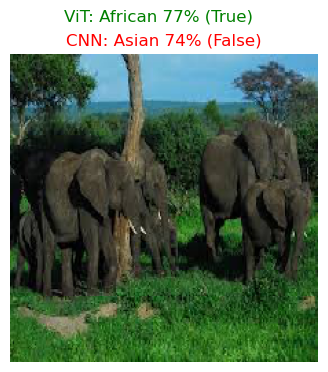

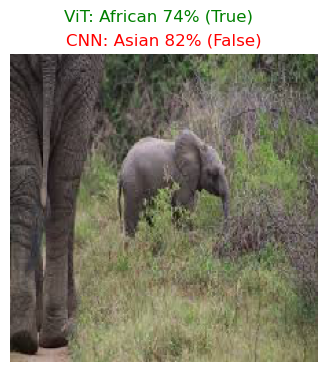

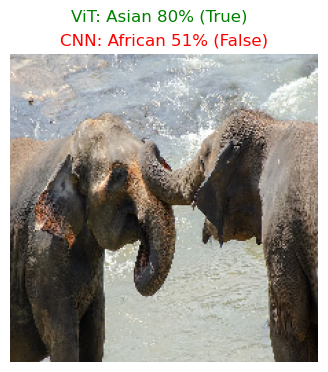

In [15]:
print("Plotting sample images that were incorrectly classified by the CNN but correctly classified by the ViT")
plotting_img_by_idx(idx_list = cnn_false_vit_hit, n_img = 3)

## 3.5 Feature Importance
Furthermore, we reasoned that examining the feature importance for both models might provide insights into why the ViT outperformed the CNN. To this end, we visualized the gradCAM activation maps (for the CNN) and the attention maps (for the ViT) for images misclassified by the CNN but correctly classified by the ViT. Although it is still challenging to draw specific conclusions from these visualizations, we believe they align with the findings of [Raghu et al. (2019)](#refs). Notably, the ViT's attention maps appeared to be spread across the entire image, suggesting better spatial retention, while the CNN seemed to focus only on specific parts of the image.

In [16]:
def plt_explain(image_path, target_size = (224, 224)):
    '''
    This function takes an image path as input and returns three images next to each other:
    1. GradCAM Activation Map for the ResNet50 Base
    2. Original (resized) Image
    3. Attention Map for the ViT Base
    
    CAVE: The two base models vit_base and ResNet50_base_pretrain need to be loaded.
    '''
    ### ViT Attention Map
    # load and process image
    img = Image.open(image_path)
    img_resized = img.resize(target_size)
    img_vit = np.array(img_resized)

    # Get the attention map
    attention_map = visualize.attention_map(model=vit_base, image=img_vit)

    ### GradCAM Activation Map
    # Load a sample image (or multiple ones)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    data = ([img], None)

    # get the gradCAM
    explainer = GradCAM()
    grid = explainer.explain(data, ResNet50_base_pretrain, class_index=0)

    ### Plot GradCAM, Original, and Attention Map
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax1.set_title('CNN GradCam')
    ax2.set_title('Original')
    ax3.set_title('ViT Attention Map')
    _ = ax1.imshow(grid)
    _ = ax2.imshow(img_resized)
    _ = ax3.imshow(attention_map)
    plt.show()

Number of images in that list: 47
Number of images to show: 3
1/1 [==============================] - 3s 3s/step


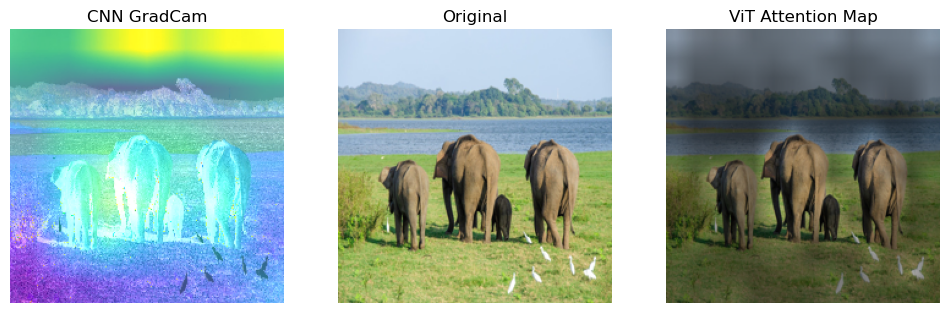

1/1 [==============================] - 2s 2s/step


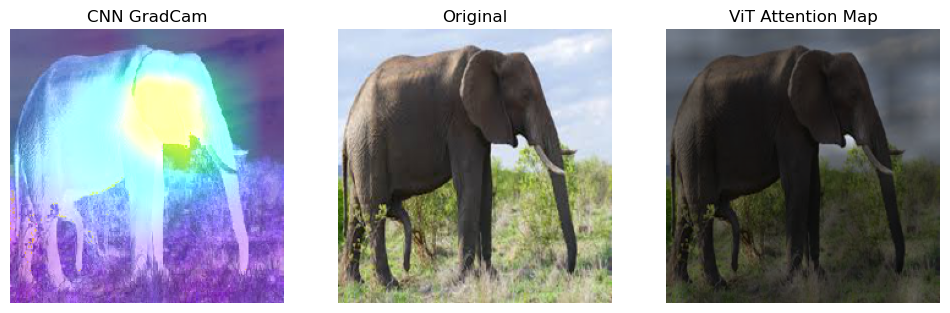

1/1 [==============================] - 2s 2s/step


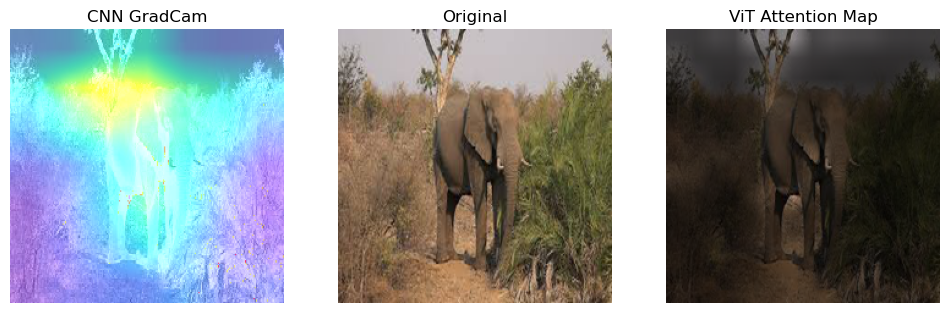

In [17]:
#For certain images, this might returns an error (I think because some images have a fourth channel). 
idx_list = np.array(list(cnn_false_vit_hit))
print("Number of images in that list: {}".format(len(idx_list)))
n_img_show = 3
print("Number of images to show: {}".format(n_img_show))
random.seed(25)
idx_list = idx_list[random.sample(range(0, len(idx_list)), n_img_show)]

for i in range(n_img_show):
    plt_explain(image_path = test_file_list[idx_list[i]])

<h1 id=conclusion style = 'font-size:32px; padding: 10px; padding-left: 15px; background-color: #E5E5E5; border-radius: 10px;'>
    <b>
        4. Conclusion
    </b>
</h1>


In conclusion, our research project successfully demonstrated the superior performance of a Vision Transformers (ViT) architecture over a Convolutional Neural Network (CNN) architecture in the specific task of classifying Japanese Art and Art Nouveau styles from the "WikiArt" dataset. The ViT model achieved an impressive 94.3% test data accuracy, significantly surpassing the CNN's 76.4% test data accuracy, and even exceeding the average human benchmark accuracy of 82.3% (n=43) we found.

Throughout the model training phase, it became evident that some strategies were notably more efficient in enhancing performance. Notably, increasing the number of training epochs proved beneficial for the ViT. However, our training epochs for both models did not reach 100 epochs due to early stopping mechanisms. Data augmentation and dropout played a part in the improvements, yet their effect was comparatively modest.

Analyzing the confusion matrices, we observed a balanced error distribution for both models, with neither showing a distinct bias toward misclassifying one art style over the other. This indicates a well-rounded performance in the binary classification task.

Most intriguingly, our examination of the attention maps from the ViT and the gradient-weighted class activation mapping (Grad-CAM) of the CNN revealed differences in how each model processes images. In instances where the ViT correctly classified images that the CNN did not, we observed that the ViT spread its attention more evenly across the whole image, while the CNN focused more on specific parts. These findings highlight the unique capabilities of ViTs in capturing and utilizing spatial aspects and the overall composition of images, arguably a critical factor in the nuanced domain of art style classification.

<h1 id=refs style = 'font-size:32px; padding: 10px; padding-left: 15px; background-color: #E5E5E5; border-radius: 10px;'>
    <b>
        5. References
    </b>
</h1> 


Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2021). An image is worth 16x16 words: Transformers for image recognition at scale. *arXiv preprint arXiv:2010.11929*.

Rebollar, I. S., & Graña, M. (2022). Deep Learning Artwork Style 
Prediction and Similarity Detection. In J. M. Ferrández Vicente et al. 
(Eds.), *IWINAC 2022, LNCS 13259* (pp. 289-297). Springer Nature Switzerland AG. [https://doi.org/10.1007](https://doi.org/10.1007/978-3-031-06527-9_28&#8203;%60%60%E3%80%90oaicite:1%E3%80%91%60%60&#8203;&#8203;%60%60%E3%80%90oaicite:0%E3%80%91%60%60&#8203)

Raghu, A., Raghu, M., Bengio, S., & Vinyals, O. (2019). Rapid learning or feature reuse? towards understanding the effectiveness of maml. *arXiv preprint arXiv:1909.09157*.

Maurício, J.; Domingues, I.; Bernardino, J. Comparing Vision Transformers and Convolutional Neural Networks for Image Classification: A Literature Review. Appl. Sci. 2023, 13, 5521. https:// [doi.org/10.3390/app13095521](http://doi.org/10.3390/app13095521)

<h1 id=labor style = 'font-size:32px; padding: 10px; padding-left: 15px; background-color: #E5E5E5; border-radius: 10px;'>
    <b>
        6. Division of Labor
    </b>
</h1> 

* Lutz: 
 * Model saving & loading process
 * Setting up the CNN
 * Visalization of GradCAM
 * Visualization of results
 * Simplifying code
* Jakov:
 * Setting up the ViT
 * Visualization of ViT attention map
 * Data augmentation
 * Notebook guiding
* Daniel: 
 * Model fine tuning
 * Misses
 * Human benchmark
 * Introduction & conclusion text
* Everybody:
 * Notebook organisation
 * Literature check
 * FineTuning decisions
 * Interpretation & Discussion
